# BEE 4750 Homework 5: Mixed Integer and Stochastic Programming

**Name**:

**ID**:

> **Due Date**
>
> Thursday, 12/05/24, 9:00pm

## Overview

### Instructions

-   In Problem 1, you will use mixed integer programming to solve a
    waste load allocation problem.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [2]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add("HiGHS")
Pkg.add("DataFrames")
Pkg.add("GraphRecipes")
Pkg.add("Plots")
Pkg.add("Measures")
Pkg.add("MarkdownTables")

  Activating project at `c:\Users\FM's Laptop\Downloads\College\BEE 4750\HW\HW5`
Precompiling project...
  ✓ MarkdownTables
  ✓ StructArrays
  ✓ StructArrays → StructArraysLinearAlgebraExt
  ✓ StructArrays → StructArraysAdaptExt
  ✓ StructArrays → StructArraysSparseArraysExt
  ✓ StructArrays → StructArraysStaticArraysExt
  ✓ Graphs
  ✓ GeometryBasics
  ✓ HiGHS
  ✓ NetworkLayout
  ✓ NetworkLayout → NetworkLayoutGraphsExt
  ✓ Plots → GeometryBasicsExt
  ✓ GraphRecipes
  13 dependencies successfully precompiled in 61 seconds. 219 already precompiled.
    Updating registry at `C:\Users\FM's Laptop\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\FM's Laptop\Downloads\College\BEE 4750\HW\HW5\Project.toml`
  No Changes to `C:\Users\FM's Laptop\Downloads\College\BEE 4750\HW\HW5\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\FM's Laptop\Downloads\College\BEE 4750\HW\HW5\Project.toml`
  No Changes to `C:\Users\FM's Laptop\Down

In [3]:
using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables

## Problems (Total: 30 Points)

### Problem 1 (30 points)

Three cities are developing a coordinated municipal solid waste (MSW)
disposal plan. Three disposal alternatives are being considered: a
landfill (LF), a materials recycling facility (MRF), and a
waste-to-energy facility (WTE). The capacities of these facilities and
the fees for operation and disposal are provided below.

-   **LF**: Capacity 200 Mg, fixed cost \$2000/day, tipping cost
    \$50/Mg;
-   **MRF**: Capacity 350 Mg, fixed cost \$1500/day, tipping cost
    \$7/Mg, recycling cost \$40/Mg recycled;
-   **WTE**: Capacity 210 Mg, fixed cost \$2500/day, tipping cost
    \$60/Mg;

The MRF recycling rate is 40%, and the ash fraction of non-recycled
waste is 16% and of recycled waste is 14%. Transportation costs are
\$1.5/Mg-km, and the relative distances between the cities and
facilities are provided in the table below.

| **City/Facility** | **Landfill (km)** | **MRF (km)** | **WTE (km)** |
|:-----------------:|:-----------------:|:------------:|:------------:|
|         1         |         5         |      30      |      15      |
|         2         |        15         |      25      |      10      |
|         3         |        13         |      45      |      20      |
|        LF         |        \-         |      32      |      18      |
|        MRF        |        32         |      \-      |      15      |
|        WTE        |        18         |      15      |      \-      |

The fixed costs associated with the disposal options are incurred only
if the particular disposal option is implemented. The three cities
produce 100, 90, and 120 Mg/day of solid waste, respectively, with the
composition provided in the table below.

**Reminder**: Use `round(x; digits=n)` to report values to the
appropriate precision!

**In this problem**:

-   Formulate the waste load allocation problem and implement it in
    `JuMP`.
-   Draw a diagram showing the flows of waste between the cities and the
    facilities. Which facilities (if any) will not be used? Does this
    solution make sense?

In [22]:
using JuMP, HiGHS

# Define the model
model = Model(HiGHS.Optimizer)

# Parameters where the order is [LF, MRF, WTE]
city_waste = [100, 90, 120]  # Mg/day
facility_capacities = [200, 350, 210]  # Mg
fixed_costs = [2000, 1500, 2500]  # $/day
tipping_costs = [50, 7, 60]  # $/Mg
recycling_cost = 40  # $/Mg
transport_cost = 1.5  # $/Mg-km
distances = [
    5 30 15;  # city 1
    15 25 10;  # city 2
    13 45 20  # city 3
]  # City to facilities
facility_to_facility_distances = [
    0 32 18;  # LF to other facilities
    32 0 15;  # MRF to other facilities
    18 15 0  # WTE to other facilities
]

recycling_rate = 0.4
ash_fractions = [0.16, 0.14]  # Non-recycled, recycled fractions

# Decision variables
@variable(model, x[1:3, 1:3] >= 0)  # Waste sent from city i to facility j
@variable(model, r[1:3, 1:3] >= 0)  # Residual waste from facility j to k
@variable(model, use_facility[1:3], Bin)  # Whether a facility is used

# Objective: Minimize total cost
@objective(
    model, Min,
    sum(transport_cost * distances[i, j] * x[i, j] for i in 1:3, j in 1:3) +  # City-to-facility transport
    sum(transport_cost * facility_to_facility_distances[j, k] * r[j, k] for j in 1:3, k in 1:3) +  # Facility-to-facility transport
    sum(fixed_costs[j] * use_facility[j] for j in 1:3) +  # Fixed costs for used facilities
    sum(tipping_costs[j] * x[i, j] for i in 1:3, j in 1:3) +  # Tipping costs
    recycling_cost * recycling_rate * sum(x[i, 2] for i in 1:3)  # Recycling costs
)

# Constraints
# Balance waste generated and disposed
for i in 1:3
    @constraint(model, sum(x[i, j] for j in 1:3) == city_waste[i])
end

# Capacity constraints for each facility
for j in 1:3
    @constraint(
        model,
        sum(x[i, j] for i in 1:3) + sum(r[k, j] for k in 1:3) <= facility_capacities[j] * use_facility[j]
    )
end

# Residual ash constraint for MRF
@constraint(
    model,
    sum(r[2, 1] for k in 1:3) + sum(r[2, 3] for k in 1:3) ==
    0.6 * (sum(x[i, 2] for i in 1:3) + sum(x[i, 3] for i in 1:3))
)

# Commitment constraints for three facilities
@constraint(model, commit1, sum(x[i, 1] for i in 1:3) <= facility_capacities[1] * use_facility[1])
@constraint(model, commit2, sum(x[i, 2] for i in 1:3) <= facility_capacities[2] * use_facility[2])
@constraint(model, commit3, sum(x[i, 3] for i in 1:3) <= facility_capacities[3] * use_facility[3])

# Solve the model
optimize!(model)
print(model)
    
# Output results
# for j in 1:3
#     println("Facility $j Used: ", value(use_facility[j]) == 1 ? "Yes" : "No")
# end
# println("\nWaste allocation (City to Facility):")
# for i in 1:3, j in 1:3
#     println("City $i to Facility $j: ", round(value(x[i, j]); digits=2), " Mg/day")
# end
# println("\nResidual waste (Facility to Facility):")
# for j in 1:3, k in 1:3
#     println("Facility $j to Facility $k: ", round(value(r[j, k]); digits=2), " Mg/day")
# end


Running HiGHS 1.8.1 (git hash: 4a7f24ac6): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [6e-01, 4e+02]
  Cost   [2e+01, 2e+03]
  Bound  [1e+00, 1e+00]
  RHS    [9e+01, 1e+02]
Presolving model
10 rows, 14 cols, 43 nonzeros  0s
9 rows, 14 cols, 39 nonzeros  0s

Solving MIP model with:
   9 rows
   14 cols (3 binary, 0 integer, 0 implied int., 11 continuous)
   39 nonzeros
MIP-Timing:     0.00042 - starting analytic centre calculation

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

      

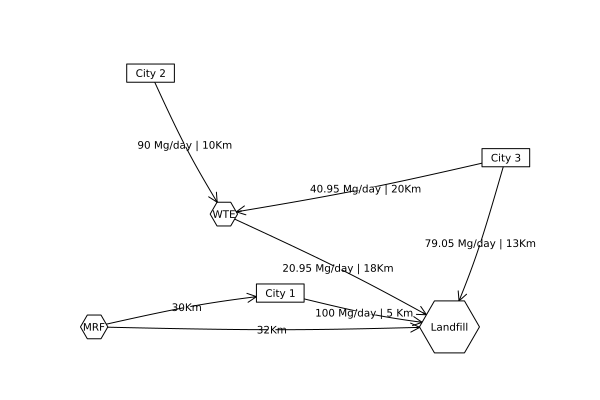

In [128]:
# Adjacency matrix for 6 nodes
A = [0 0 0 0 1 0;   # Edge from City 1 Landfill
     0 0 0 0 0 1;   # Edge from City 2 to WTE
     0 0 0 0 1 1;   # Edge from City 3 to Landfill + WTE
     1 0 0 0 1 0;   # MRF
     0 0 0 0 0 0;   # Landfill (updated)
     0 0 0 0 1 0];  # WTE to Landfill

# Node labels
names = ["City 1", "City 2", "City 3", "MRF", "Landfill", "WTE"]

# Edge labels (flow values)
edge_labels = Dict(
    (1, 5) => "100 Mg/day | 5 Km",  
    (2, 6) => "90 Mg/day | 10Km",   
    (3, 5) => "79.05 Mg/day | 13Km",
    (3, 6) => "40.95 Mg/day | 20Km",
    (6, 5) => "20.95 Mg/day | 18Km", 
    (4, 1) => "30Km", 
    (4, 5) => "32Km",    
)

# Shapes for nodes
shapes = [:rect, :rect, :rect, :hexagon, :hexagon, :hexagon]

# Node positions for 6 nodes
xpos = [1.5, -0.8, 5.5, -1.8, 4.5, 0.5]
ypos = [0.1, 4, 2.5, -0.5, -0.5, 1.5]

# Create and display the graph
p = graphplot(
    A,
    names=names,
    edgelabel=edge_labels,
    markersize=0.45,      # Adjust marker size for visibility
    markershapes=shapes, # Set node shapes
    markercolor=:white,  # Node background color
    x=xpos,              # Set x positions
    y=ypos               # Set y positions
)

display(p)


## References

List any external references consulted, including classmates.